In [12]:
# Importing libraries
import pandas as pd
import numpy as np

from datetime import datetime

from string import ascii_letters

# Removing width limit
#pd.options.display.max_columns = None

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Not used below
from scipy import stats
from scipy.stats import gaussian_kde
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [13]:
#Choosing data frame for air pollution
path = 'data/Kolkata_PM2.5_2019_YTD.csv'
df1e = pd.read_csv(path)

#print(df1e.shape)

path = 'data/Kolkata_PM2.5_2020_01_MTD.csv'
df1f = pd.read_csv(path)

#print(df1f.shape)

df1_1 = pd.concat([df1e, df1f])
#print(df1_1.shape)

df1_1.drop(['Site', 'Parameter', 'Year', 'Month', 'Day', 'Hour', 'NowCast Conc.', 'AQI', 'AQI Category', 'Conc. Unit', 'Duration'], axis = 1, inplace=True)

# Generate counts
#df1_1['QC Name'].value_counts()

#indexNames = df1e[df1e['QC Name'] == 'Missing'].index
#df1e.drop(indexNames, inplace=True)

#indexNames = df1e[df1e['QC Name'] == 'Invalid'].index
#df1e.drop(indexNames, inplace=True)

df1 = df1_1[~df1_1['QC Name'].isin(['Missing','Invalid'])]

df1.drop(['QC Name'], axis = 1, inplace=True)
#df1ef.plot()
#plt.show()

df1['Date (LT)'] =  pd.to_datetime(df1['Date (LT)'], format='%Y-%m-%d %I:%M %p')

df1.head()

#df1.plot()
#plt.show()

C:\Users\shuvr\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Date (LT),Raw Conc.
0,2019-01-01 01:00:00,230.0
1,2019-01-01 02:00:00,237.0
2,2019-01-01 03:00:00,225.0
3,2019-01-01 04:00:00,213.0
4,2019-01-01 05:00:00,200.0


In [14]:
#Choosing data frame for weather
path = 'data/kol_beh_wea_hr.csv'
df2 = pd.read_csv(path)

# Assigning values to wind direction (by degrees) and condition
labels = {'Wind': {'E': 360, 'ENE': 22.5, 'NE': 45, 'NNE': 67.5,
                    'N': 90, 'NNW': 112.5, 'NW': 135, 'WNW': 157.5,
                    'W': 180, 'WSW': 202.5, 'SW': 225, 'SSW': 247.5,
                    'S': 270, 'SSE': 292.5, 'SE': 315, 'ESE': 337.5,
                    'CALM': 0},
            'Condition': {'Haze': 1, 'Fog': 2, 'Light Rain': 3, 'Rain': 4, 'Light Rain with Thunder': 5,
                         'T-Storm': 6, 'Light Rain / Windy': 7, 'Drizzle': 8, 'Light Drizzle': 9}}

df2.replace(labels, inplace=True)
df2.head()

#df2['Condition'].value_counts() #generate counts

# Displaying data
df2.head()
#display(df2)

# Dropping units
#df['Temperature'] = df['Temperature'].map(lambda x: x.lstrip('whatever').rstrip('whatever'))
df2['Temperature'] = df2['Temperature'].map(lambda x: x.rstrip('F'))
df2['Dew Point'] = df2['Dew Point'].map(lambda x: x.rstrip('F'))
df2['Humidity'] = df2['Humidity'].map(lambda x: x.rstrip('%'))
df2['Wind Speed'] = df2['Wind Speed'].map(lambda x: x.rstrip('mph'))
df2['Wind Gust'] = df2['Wind Gust'].map(lambda x: x.rstrip('mph'))
df2['Pressure'] = df2['Pressure'].map(lambda x: x.rstrip('in'))
df2['Precip.'] = df2['Precip.'].map(lambda x: x.rstrip('in'))

df2['Date (LT)'] = df2['Date'].astype(str) + ' ' + df2['Time']

# Drop old date and time columns
df2.drop(['Date', 'Time'], axis = 1, inplace=True)

df2['Date (LT)'] =  pd.to_datetime(df2['Date (LT)'], format='%Y-%m-%d %I:%M %p')

#df2.head()

#df2.plot()
#plt.show()

In [15]:
df = df1.merge(df2, left_on='Date (LT)', right_on='Date (LT)')

In [16]:
df['Raw Conc.'] = df['Raw Conc.'].astype(float)
df['Temperature'] = df['Temperature'].astype(float)
df['Dew Point'] = df['Dew Point'].astype(float)
df['Humidity'] = df['Humidity'].astype(float)
df['Wind'] = df['Wind'].astype(float)
df['Wind Speed'] = df['Wind Speed'].astype(float)
df['Wind Gust'] = df['Wind Gust'].astype(float)
df['Pressure'] = df['Pressure'].astype(float)
df['Precip.'] = df['Precip.'].astype(float)
df['Condition'] = df['Condition'].astype(float)

#Preprocess by filling in 0's for NaN's (blanks)
df.fillna(0, inplace=True)

df.head()

df.to_csv('data/combined_data.csv')

In [22]:


#easy way to get lagged features - do everything in 8 hour chunks
#want new features to include weather information from 8, 16, and 24 hours previous
df.rename(columns = {"Unnamed: 0": "Date (LT)"}, inplace = True) 
# Troublesome line
#df = df.set_index('Date (LT)')
df.index = pd.to_datetime(df.index)

df1h = df.resample('1H').max()
df_past = pd.concat([df1h, df1h.shift(1), df1h.shift(2), df1h.shift(3)], axis=1)
df_past.columns = ['Raw Conc.', 'Temperature', 'Dew Point', 'Humidity', 'Wind', 'Wind Speed', 'Wind Gust',
                   'Pressure', 'Precip.', 'Condition',
                   'Raw Conc.-1', 'Temperature-1', 'Dew Point-1', 'Humidity-1', 'Wind-1', 'Wind Speed-1', 'Wind Gust-1',
                   'Pressure-1', 'Precip.-1', 'Condition-1',
                   'Raw Conc.-2', 'Temperature-2', 'Dew Point-2', 'Humidity-2', 'Wind-2', 'Wind Speed-2', 'Wind Gust-2',
                   'Pressure-2', 'Precip.-2', 'Condition-2',
                   'Raw Conc.-3', 'Temperature-3', 'Dew Point-3', 'Humidity-3', 'Wind-3', 'Wind Speed-3', 'Wind Gust-3',
                   'Pressure-3', 'Precip.-3', 'Condition-3']
df_past.head()

# now look at weather data 8, 16, 24, 32, 40, and 48 hours into the future
# for real-time data I will use the weather forecast
df_future = pd.concat([df1h.shift(-1), df1h.shift(-2), df1h.shift(-3), df1h.shift(-4), df1h.shift(-5), df1h.shift(-6)], axis=1)
df_future.columns = ['Raw Conc.+1', 'Temperature+1', 'Dew Point+1', 'Humidity+1', 'Wind+1', 'Wind Speed+1', 'Wind Gust+1',
                   'Pressure+1', 'Precip.+1', 'Condition+1',
                     'Raw Conc.+2', 'Temperature+2', 'Dew Point+2', 'Humidity+2', 'Wind+2', 'Wind Speed+2', 'Wind Gust+2',
                   'Pressure+2', 'Precip.+2', 'Condition+2',
                     'Raw Conc.+3', 'Temperature+3', 'Dew Point+3', 'Humidity+3', 'Wind+3', 'Wind Speed+3', 'Wind Gust+3',
                   'Pressure+3', 'Precip.+3', 'Condition+3',
                     'Raw Conc.+4', 'Temperature+4', 'Dew Point+4', 'Humidity+4', 'Wind+4', 'Wind Speed+4', 'Wind Gust+4',
                   'Pressure+4', 'Precip.+4', 'Condition+4',
                     'Raw Conc.+5', 'Temperature+5', 'Dew Point+5', 'Humidity+5', 'Wind+5', 'Wind Speed+5', 'Wind Gust+5',
                   'Pressure+5', 'Precip.+5', 'Condition+5',
                     'Raw Conc.+6', 'Temperature+6', 'Dew Point+6', 'Humidity+6', 'Wind+6', 'Wind Speed+6', 'Wind Gust+6',
                   'Pressure+6', 'Precip.+6', 'Condition+6']
df_future.tail(5)

#combine the future data and past data
df_lags = pd.merge(df_past, df_future, how = 'outer', left_index = True, right_index = True)
df_lags.tail(5)

#include month, hour, and day as features
df_lags['Month'] = df_lags.index.strftime('%b')
df_lags['Hour'] = df_lags.index.strftime('%H')
df_lags['Day'] = df_lags.index.strftime('%a')
df_lags.tail()

,Raw Conc.,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition,...,Humidity+6,Wind+6,Wind Speed+6,Wind Gust+6,Pressure+6,Precip.+6,Condition+6,Month,Hour,Day
Date (LT),,,,,,,,,,,,,,,,,,,,,
2020-01-18 14:00:00,67.0,73.0,57.0,57.0,0.0,0.0,0.0,29.93,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan,14,Sat
2020-01-18 15:00:00,53.0,72.0,55.0,57.0,0.0,0.0,0.0,29.93,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan,15,Sat
2020-01-18 16:00:00,56.0,72.0,57.0,60.0,0.0,0.0,0.0,29.93,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan,16,Sat
2020-01-18 17:00:00,63.0,72.0,57.0,60.0,0.0,0.0,0.0,29.93,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan,17,Sat
2020-01-18 18:00:00,61.0,68.0,57.0,68.0,0.0,0.0,0.0,29.93,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan,18,Sat


In [20]:
df_lags.to_csv('data/combined_data_1hr_lags.csv')

In [56]:
np.asarray(df_lags)

array([[49.0, 82.0, 81.0, ..., 'Oct', '19', 'Sat'],
       [54.0, 81.0, 79.0, ..., 'Oct', '20', 'Sat'],
       [56.0, 79.0, 75.0, ..., 'Oct', '21', 'Sat'],
       ...,
       [56.0, 72.0, 57.0, ..., 'Jan', '16', 'Sat'],
       [63.0, 72.0, 57.0, ..., 'Jan', '17', 'Sat'],
       [61.0, 68.0, 57.0, ..., 'Jan', '18', 'Sat']], dtype=object)

In [58]:
np.asarray(df_lags)

array([[49.0, 82.0, 81.0, ..., 'Oct', '19', 'Sat'],
       [54.0, 81.0, 79.0, ..., 'Oct', '20', 'Sat'],
       [56.0, 79.0, 75.0, ..., 'Oct', '21', 'Sat'],
       ...,
       [56.0, 72.0, 57.0, ..., 'Jan', '16', 'Sat'],
       [63.0, 72.0, 57.0, ..., 'Jan', '17', 'Sat'],
       [61.0, 68.0, 57.0, ..., 'Jan', '18', 'Sat']], dtype=object)

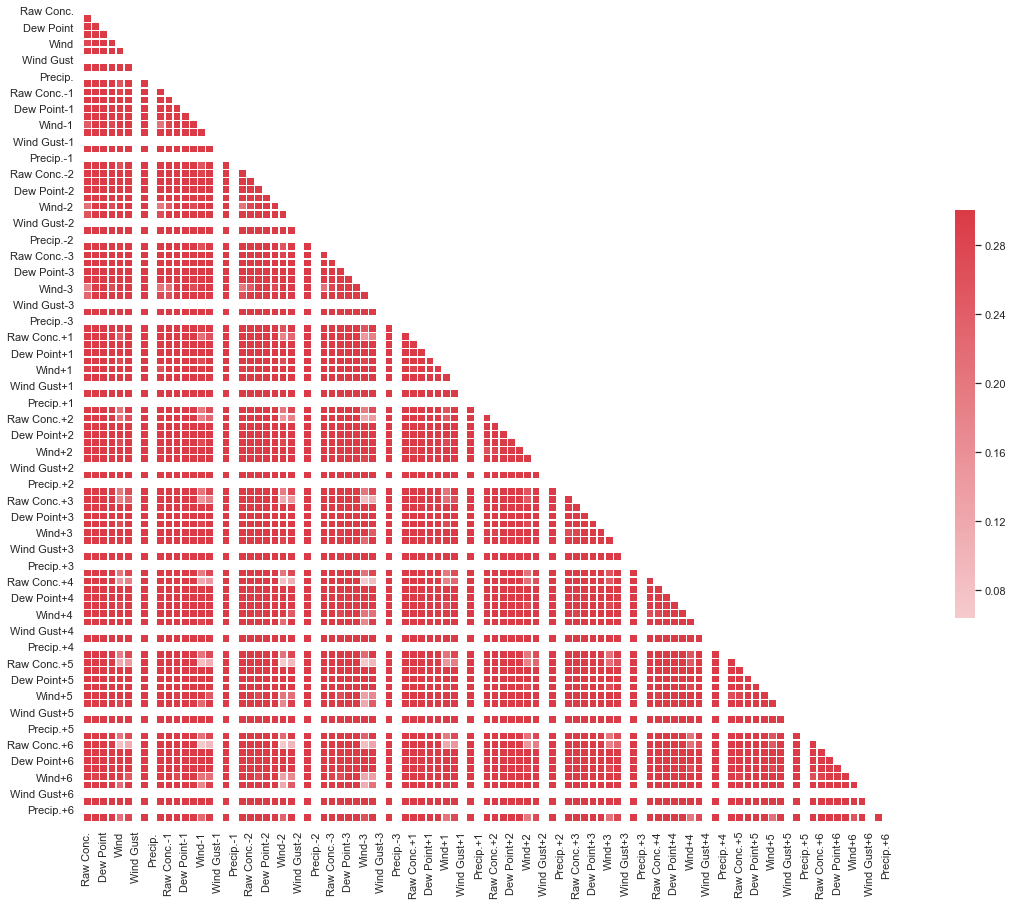

In [61]:
sns.set(style="white")

# Generate a large random dataset
#rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)),
#                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = df_lags.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [21]:
# Linear Model using Statsmodels
import statsmodels.api as sm

#X = exam_data[["HW_Mean","Quiz_Mean","Exam_Mean"]]
#X = df.drop(['Date (LT)', 'Raw Conc.'], axis=1) #choose training columns
#y = df['Raw Conc.'] #choose the target column

X = df_lags.drop(['Raw Conc.+1', 'Raw Conc.+2', 'Raw Conc.+3', 'Raw Conc.+4', 'Raw Conc.+5', 'Raw Conc.+6'], axis = 1)

X = sm.add_constant(X)

y = df_lags[['Raw Conc.+1', 'Raw Conc.+2', 'Raw Conc.+3', 'Raw Conc.+4', 'Raw Conc.+5', 'Raw Conc.+6']]

# Fit the linear model
linear_model_1 = sm.OLS(y, X).fit()
#linear_model_1 = sm.OLS(y.astype(float), X.astype(float)).fit()
predictions = linear_model_1.predict(X)

# Print the regression results
linear_model_1.summary()

# First entry is the axis
input_date = '2020-01-18 14:00:00'
input_values = [1,82,81,94,135,2,0,29.87,0,1]
print(linear_model_1.predict(input_values))

# Calculate the error
#from statsmodels.tools.eval_measures import rmse

# Generate predictions
#ypred = linear_model_1.predict(X.astype(float))
#print(ypred)

# Calculate and print rmse
#rmse = rmse(y.astype(float), ypred)
#print(rmse)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [23]:
#from sklearn.model_selection import train_test_split as tts

#train_X, val_X, train_y, val_y = tts(X, y, random_state = 1)

# Linear Model using scikitlearn
#from sklearn import linear_model as lm

#linear_model_2 = lm.LinearRegression()
#results = linear_model_2.fit(X,y)

#print (linear_model_2.intercept_, linear_model_2.coef_)

# MM
#X = df.drop(['column'], axis=1) #choose training columns
#y = df['column'] #choose the target column

X = df.drop(['Date (LT)', 'Raw Conc.'], axis=1) #choose training columns
y = df['Raw Conc.'] #choose the target column

# Split data into training and validation data
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

predictions = lm.predict(X_test)

plt.scatter(y_test,predictions)

from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

KeyError: "['Date (LT)'] not found in axis"

In [ ]:
from sklearn.tree import DecisionTreeRegressor as dtr

# Fit Decision Tree Model
exam_model = dtr(random_state = 1)
exam_model.fit(X_train,y_train)

# Predict using DTM
from sklearn.metrics import mean_absolute_error as mae
val_fin = exam_model.predict(X_test)

# Display MAE
print(mae(y_test, val_fin))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Fit Random Forest Model
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train, y_train)

# Predict using RFM
melb_preds = forest_model.predict(X_test)

# Display MAE
print(mean_absolute_error(y_test, melb_preds))